# Graficos de campos de vento/temperatura

In [1]:
from siphon.catalog import TDSCatalog

In [2]:
# si el catalogo que se desea es de 0.25 grados
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')

# lista de colecciones
print(best_gfs.datasets)

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [3]:
best_ds = list(best_gfs.datasets.values())[1]

# diccionario de urls disponibles con la información
best_ds.access_urls

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'JupyterNotebook': 'https://thredds.ucar.edu/thredds/notebook/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grid/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best'}

In [4]:
best_ds = best_gfs.datasets[0]
ncss =best_ds.subset()
query = ncss.query()

Requerimiento de datos, para eso recurrimos a la función `query.lonlat_box()`, recuerda que en este caso no se trabaja con `time_range`

In [5]:
from datetime import datetime, timedelta, timezone

now = datetime.now(timezone.utc)
# buscando la posición de lima
query.lonlat_box(west=270, north=0, east=300, south=-20).vertical_level(100000).time(now)
query.accept('netcdf4')
query.variables('Temperature_isobaric', 
                'Relative_humidity_isobaric', 
                'u-component_of_wind_isobaric', 
                'v-component_of_wind_isobaric')

# haciendo el requerimiento de los datos
data = ncss.get_data(query)

Para dejar mas facil el trabajo con nuestro archivo utilicemos el `xarray`

In [6]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data_2 = xr.open_dataset(NetCDF4DataStore(data))
list(data.variables.keys())

['reftime',
 'validtime3',
 'latitude',
 'isobaric',
 'validtime3Forecast',
 'longitude',
 'Relative_humidity_isobaric',
 'Temperature_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric',
 'LatLon_721X1440-0p13S-180p00E']

## Trabajando con `geocat-viz`

In [7]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt

from cartopy.feature import ShapelyFeature, OCEAN, LAKES
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth

import geocat.datafiles as gdf
import cmaps
import geocat.viz as gv

In [8]:
# vamos a trabajar la longitud con -180, el modelo retorno de 0 a 360
lon = data_2.longitude.data - 360
lat = data_2.latitude.data
T = data_2.Temperature_isobaric.data[0,0,0] - 273.15
U = data_2['u-component_of_wind_isobaric'].data[0,0,0]
V = data_2['v-component_of_wind_isobaric'].data[0,0,0]

# generando los puntos para graficar
lon, lat = np.meshgrid(lon, lat)

In [9]:
U

array([[-2.1500123 , -0.25001222,  0.5399878 , ...,  0.5999878 ,
         0.6699878 ,  0.14998779],
       [-2.2200122 ,  0.5399878 ,  1.5799878 , ...,  0.4899878 ,
         0.4099878 ,  0.5399878 ],
       [-0.31001222,  0.3299878 ,  0.04998779, ...,  0.63998777,
         0.03998779,  0.5199878 ],
       ...,
       [-5.570012  , -5.8500123 , -5.030012  , ..., -2.0200121 ,
        -1.4200122 , -0.23001221],
       [-5.450012  , -5.590012  , -4.940012  , ..., -2.0100121 ,
        -1.1200122 , -0.2200122 ],
       [-4.650012  , -4.7300124 , -4.530012  , ..., -1.2300122 ,
        -0.2000122 ,  0.01998779]], dtype=float32)

In [10]:
# Download the Natural Earth shapefile for country boundaries at 10m resolution

projection = ccrs.PlateCarree()

# niveles de temperatura

clevs = np.linspace(10, 45, 8)

# Importando la base del colormap para trabajar
newcmp = gv.truncate_colormap(cmaps.BkBlAqGrYeOrReViWh200,
                              minval=0.1,
                              maxval=0.6,
                              n=len(clevs))

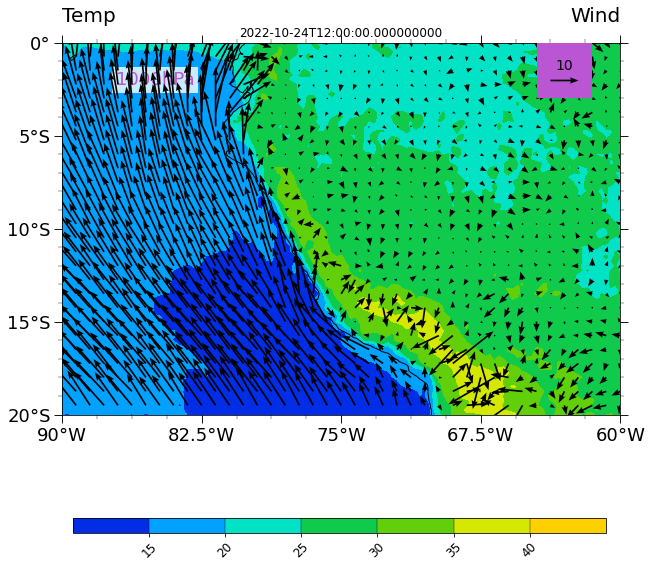

In [37]:
# Generate figure (set its size (width, height) in inches) and axes using Cartopy
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=projection)

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=projection)
ax.coastlines()
# Draw the temperature contour plot with the subselected colormap
# (Place the zorder of the contour plot at the lowest level)
cf = ax.contourf(lon, lat, T, levels=clevs, cmap=newcmp, zorder=1)

# Draw horizontal color bar
cax = plt.axes((0.14, 0.08, 0.74, 0.02))
cbar = plt.colorbar(cf,
                    ax=ax,
                    cax=cax,
                    ticks=clevs[1:-1],
                    drawedges=True,
                    orientation='horizontal')
cbar.ax.tick_params(labelsize=12, rotation=45)


# # Add the OCEAN and LAKES features on top of the contour plot
# ax.add_feature(OCEAN.with_scale('50m'), edgecolor='black', lw=1, zorder=2)

# Draw the wind quiver plot on top of everything else
Q = ax.quiver(lon[::3,::3],
              lat[::3,::3],
              U[::3,::3],
              V[::3,::3],
              color='black',
              width=.003,
              scale=100.,
              headwidth=3.75,
              zorder=4)

# # Draw the key for the quiver plot
rect = plt.Rectangle((-64.5, -3),
                     3,
                     3,
                     facecolor='mediumorchid',
                     edgecolor=None,
                     zorder=4)
ax.add_patch(rect)
ax.quiverkey(Q,
             0.9,
             0.9,
             5,
             '10',
             labelpos='N',
             color='black',
             coordinates='axes',
             fontproperties={'size': 14},
             labelsep=0.1)

# Add a text box to indicate the pressure level
props = dict(facecolor='white', edgecolor='none', alpha=0.8)
ax.text(lon.min()+5,
        lat.max()-2,
        '1000hPa',
        transform=projection,
        fontsize=18,
        ha='center',
        va='center',
        color='mediumorchid',
        bbox=props)

# Use geocat.viz.util convenience function to set axes tick values
gv.set_axes_limits_and_ticks(ax,
                             xticks=np.linspace(lon.min(), lon.max(), 5),
                             yticks=np.linspace(lat.min(), lat.max(), 5))

# Use geocat.viz.util convenience function to make plots look like NCL plots by using latitude, longitude tick labels
gv.add_lat_lon_ticklabels(ax)

# Use geocat.viz.util convenience function to add minor and major tick lines
gv.add_major_minor_ticks(ax,
                         x_minor_per_major=4,
                         y_minor_per_major=5,
                         labelsize=18)

# Use geocat.viz.util convenience function to add main title as well as titles to left and right of the plot axes.
gv.set_titles_and_labels(ax,
                         lefttitle="Temp",
                         lefttitlefontsize=20,
                         righttitle="Wind",
                         righttitlefontsize=20)

ax.set_title(f'{data_2.reftime.data[0]}')

# Show the plot
plt.show()

In [12]:
list(data_2)

['Relative_humidity_isobaric',
 'Temperature_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric',
 'LatLon_721X1440-0p13S-180p00E']

In [36]:
data_2.reftime.data

array(['2022-10-24T12:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
lon.max()

-60.0

In [15]:
lat.min()

-20.0

In [16]:
T.min()

13.009094

In [19]:
U.max()

7.279988

In [20]:
V.max()

11.884021